# Baseline model for claim classification

In this notebook, we'll explore basic ML models to train and make inferences about the veracity of environment related claims. These models, such as _linear regression_ and _naive bayes_, are simplier, faster and more easily interpretable than more advanced deep learning approaches. 

The results from this exercise will be used as reference point for the claim classification project. 

In [1]:
# import required libraries
import numpy as np 
import pandas as pd
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

### Load data

Import data from previously produced csv files

In [2]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")
val_df = pd.read_csv("../data/val_data.csv")

# remove nans. they cant be vectorized
train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

In [3]:
val_df.head()

,clean_text,label
0,there is ample evidence that earths average te...,DISPUTED
1,the ozone layer stops uv radiation from enteri...,SUPPORTS
2,despite the logarithmic relationship between c...,SUPPORTS
3,as a result the polar ice caps were quite like...,NEUTRAL
4,an additional kick was supplied by an el niño ...,NEUTRAL


### Separate features and labels

We’ll train on _clean_text_ and predict _label_

In [4]:
x_list = ['clean_text']
y_list = ['label']

x_train, y_train = train_df[x_list], train_df[y_list]
x_test, y_test   = test_df[x_list], test_df[y_list]
x_val, y_val     = val_df[x_list], val_df[y_list]

y_train = y_train.values.ravel() # flaten so it's labels are 1D
y_test  = y_test.values.ravel() # flaten so it's labels are 1D
y_val   = y_val.values.ravel() # flaten so it's labels are 1D

print(x_train.shape)
print(y_train.shape)

(1074, 1)
(1074,)


### Baseline pipeline

We'll use **TF-IDF** (Term Frequency - Inverse Document Frequency) with **Logistic Regression**

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#### Model parameter optimization
Through grid scan

In [6]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

param_grid = [
    {"ngram_range": (1,1), "max_features": 5000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 5000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 10000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 20000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 5000,  "class_weight": "balanced"},
    {"ngram_range": (1,2), "max_features": 10000, "class_weight": "balanced"},
    {"ngram_range": (1,3), "max_features": 20000, "class_weight": "balanced"},
]

results = []

for params in param_grid:
    clf_temp = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=params["ngram_range"],
            max_features=params["max_features"],
            stop_words="english"
        )),
        ("logreg", LogisticRegression(
            max_iter=2000,
            class_weight=params["class_weight"]
        ))
    ])

    clf_temp.fit(x_train["clean_text"], y_train)
    y_pred_temp = clf_temp.predict(x_test["clean_text"])

    acc = accuracy_score(y_test, y_pred_temp)
    f1_macro = f1_score(y_test, y_pred_temp, average="macro")

    results.append({
        "ngram_range": params["ngram_range"],
        "max_features": params["max_features"],
        "class_weight": params["class_weight"],
        "accuracy": acc,
        "f1_macro": f1_macro
    })

# Put in table
results_df = pd.DataFrame(results)
print(results_df)

  ngram_range  max_features class_weight  accuracy  f1_macro
0      (1, 1)          5000         None  0.506494  0.290874
1      (1, 2)          5000         None  0.515152  0.296471
2      (1, 2)         10000         None  0.502165  0.284468
3      (1, 2)         20000         None  0.510823  0.285039
4      (1, 2)          5000     balanced  0.441558  0.381096
5      (1, 2)         10000     balanced  0.415584  0.343348
6      (1, 3)         20000     balanced  0.432900  0.348810


Chose parameters based on tradeoff between accuracy and f1

In [7]:
max_features = 5000
ngram_range=(1,2)
class_weight="balanced"

### Baseline performance

Chose a model between logistic regression, random forest, and xgboost based on overall performance.

In [8]:
from sklearn.metrics import classification_report

In [9]:
from src.models import *
from sklearn.preprocessing import LabelEncoder

# XGBooost needs encoded labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

ModuleNotFoundError: No module named 'src.models'

In [10]:
log_model = train_classic_model(x_train, y_train_enc, "logreg", ngram_range=ngram_range, max_features=max_features, class_weight=class_weight)
rf_model  = train_classic_model(x_train, y_train_enc, "rf", ngram_range=ngram_range, max_features=max_features, class_weight=class_weight)
xgb_model = train_classic_model(x_train, y_train_enc, "xgb", ngram_range=ngram_range, max_features=max_features, class_weight=class_weight)

results = []

models = {
        "Logistic Regression": log_model,
        "Random Forest": rf_model,
        "XGBoost": xgb_model
}

for name, model in models.items():
    
    preds = model.predict(x_test)

    acc = accuracy_score(y_test_enc, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test_enc, preds, average="weighted", zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3)
    })

pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.442,0.477,0.442,0.454
1,Random Forest,0.472,0.454,0.472,0.452
2,XGBoost,0.407,0.416,0.407,0.410


Picking model to set baseline. Might re-optimize parameters later.

In [11]:
this_model = xgb_model
y_pred = this_model.predict(x_test)

# Decode back into strings
y_pred_str = le.inverse_transform(y_pred)

# Same for y_test if you want consistency
y_test_str = le.inverse_transform(y_test_enc)

acc = accuracy_score(y_test_str, y_pred_str)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_str, y_pred_str, average="weighted", zero_division=0)
        
# Classification Report
print(classification_report(y_test_str, y_pred_str, zero_division=0))

              precision    recall  f1-score   support

    DISPUTED       0.06      0.06      0.06        17
     NEUTRAL       0.37      0.43      0.40        69
     REFUTES       0.23      0.23      0.23        30
    SUPPORTS       0.54      0.49      0.51       115

    accuracy                           0.41       231
   macro avg       0.30      0.30      0.30       231
weighted avg       0.42      0.41      0.41       231



#### Confusion matrix

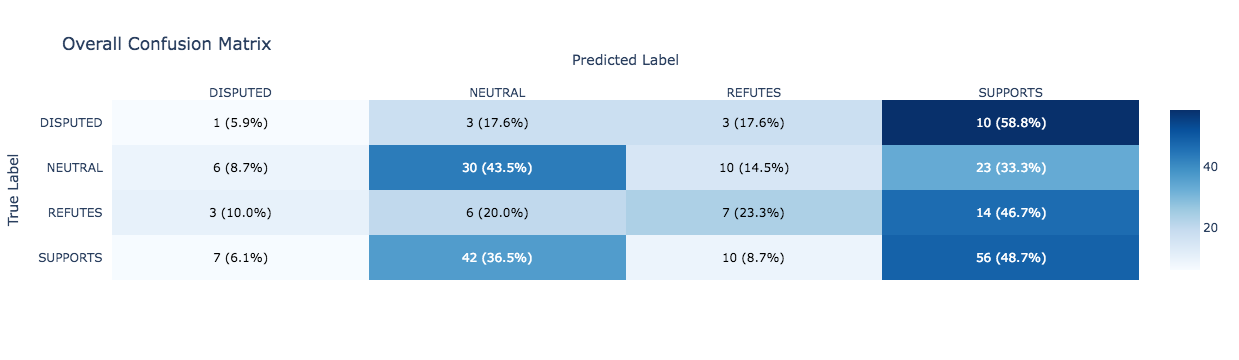

In [12]:
from src.viz import * 

labels_in_test = list(np.unique(y_test_str))

# Overall confusion matrix
plotly_confusion_matrix(y_test_str, y_pred_str, labels=labels_in_test, title="Overall Confusion Matrix")

#### Feature importance

Coefficients tell us what words are most indicative of _FAKE_ vs _REAL_ claims.

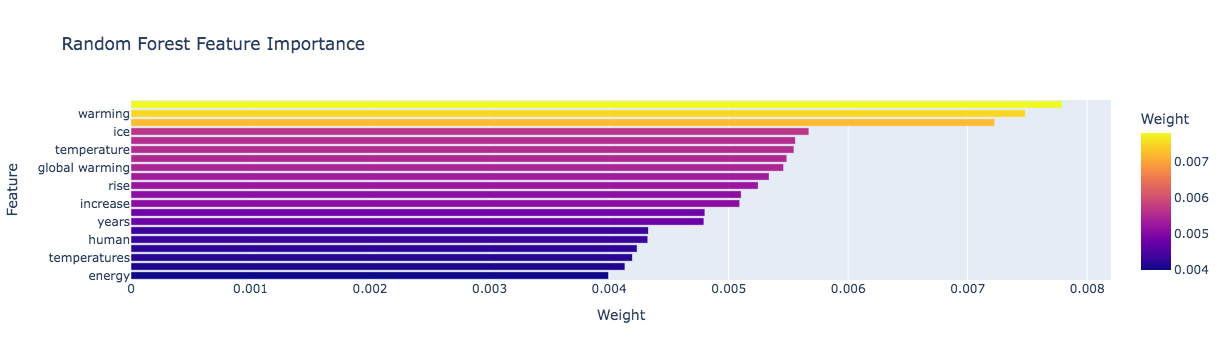

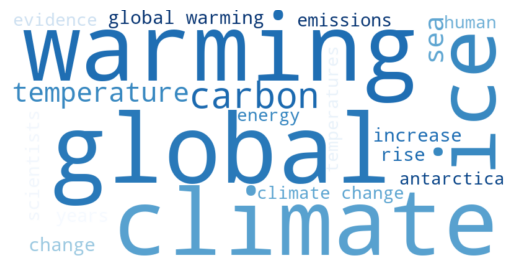

In [14]:
from src.utils import * 

fw = get_feature_importance(rf_model, top_n=20)   # works with RF, XGB or LogReg
plot_feature_importance(fw, "Random Forest Feature Importance")
plot_wordcloud(fw, model_type="rf")